# Train and Test neural network

#### Imports of modules and cars dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython.display import clear_output
from tensorflow import keras
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from dataset import cars_categorical_train, cars_numerical_train, cars_categorical_test, cars_numerical_test, y_train, y_test
from tensorflow.keras.optimizers import SGD
from keras import Input
from keras.layers import Reshape, Embedding


train_ratio = 0.85
test_ratio = 1 - train_ratio
validation_ratio = 0.2

#### Show datatypes

In [17]:
print(cars_categorical_train.dtypes)

airbag                int8
climate_control       int8
color                 int8
condition             int8
emission_class        int8
first_registration    int8
fuel                  int8
gear                  int8
interior              int8
manufacturer          int8
num_of_owners         int8
cabrio                int8
kleinwagen            int8
kombi                 int8
limousine             int8
sportwagen            int8
gelaendewagen         int8
van                   int8
dtype: object


#### Create class to plot losses after every generation

In [3]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        clear_output(wait=True)
        if len(self.x) > 20:
            plt.plot(self.x[len(self.x)-20:], self.losses[len(self.x)-20:], label="loss")
            plt.plot(self.x[len(self.x)-20:], self.val_losses[len(self.x)-20:], label="val_loss")
        else:
            plt.plot(self.x, self.losses, label="loss")
            plt.plot(self.x, self.val_losses, label="val_loss")

        plt.legend()
        plt.show()

plot_losses = PlotLosses()

#### Build model

In [4]:
inputs = []
embeddings = []
for c in range(len(cars_categorical_train.columns)):
    input_ = Input(shape=(1,),name='input_'+str(cars_categorical_train.columns[c]).replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss"))
    no_of_unique_cat  = len(cars_categorical_train.iloc[:,c].unique())
    embedding_size = min(np.ceil(no_of_unique_cat/2), 50 )
    embedding_size = int(embedding_size)
    embedding = Embedding(no_of_unique_cat+1, embedding_size, input_length = 1,name='embedding_'+str(cars_categorical_train.columns[c]).replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss"))(input_)
    embedding = Reshape(target_shape=(embedding_size,),name='reshape_'+str(cars_categorical_train.columns[c]).replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss"))(embedding)
    inputs.append(input_)
    embeddings.append(embedding)

cat_concat = tf.keras.layers.Concatenate(name="concat_categorical")(embeddings)
cat_dense = tf.keras.layers.Dense(4096, activation='selu', kernel_initializer='lecun_normal')(cat_concat)

input_numeric = tf.keras.layers.Input(shape=(len(cars_numerical_train.columns),), name='input_continuous')
batch_norm = tf.keras.layers.BatchNormalization(name='batch_norm')(input_numeric)
norm = tf.keras.layers.LayerNormalization(axis=1)(batch_norm)
inputs.append(input_numeric)
numeric_dense = tf.keras.layers.Dense(4096, activation='selu', kernel_initializer='lecun_normal')(norm)

x = tf.keras.layers.Concatenate(name="concat")([numeric_dense, cat_dense])

x = tf.keras.layers.Dense(2048, activation='selu', kernel_initializer='lecun_normal')(x)
x = tf.keras.layers.Dense(1024, activation='selu', kernel_initializer='lecun_normal')(x)
x = tf.keras.layers.Dense(2048, activation='selu', kernel_initializer='lecun_normal')(x)

out = tf.keras.layers.Dense(1, activation='relu', name='output')(x)


## compile and train model

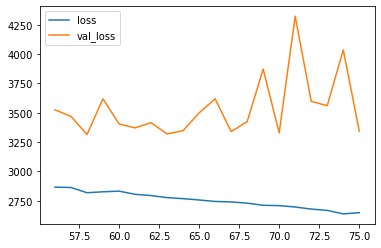

1365/1365 [==============================] - 12s 9ms/step - loss: 2648.3787 - mean_absolute_error: 2648.3787 - val_loss: 3343.2151 - val_mean_absolute_error: 3343.2151


In [5]:
opt = SGD(lr=0.0001)

model = tf.keras.models.Model(inputs=inputs, outputs=out)
model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mean_absolute_error'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode="min",restore_best_weights=True, min_delta=20)
history = model.fit([cars_categorical_train[x] for x in cars_categorical_train.columns] + [cars_numerical_train], y_train, epochs=20000, batch_size=100, callbacks=[plot_losses, early_stopping], validation_split=validation_ratio/train_ratio)

#### misc

In [6]:
def set_color(_fig, _ax):
    _fig.patch.set_facecolor('#1b212c')
    _ax.patch.set_facecolor('#1b212c')
    _ax.spines['bottom'].set_color('white')
    _ax.spines['top'].set_color('white')
    _ax.spines['left'].set_color('white')
    _ax.spines['right'].set_color('white')
    _ax.xaxis.label.set_color('white')
    _ax.yaxis.label.set_color('white')
    _ax.grid(alpha=0.1)
    _ax.title.set_color('white')
    _ax.tick_params(axis='x', colors='white')
    _ax.tick_params(axis='y', colors='white')

#### plot whole history

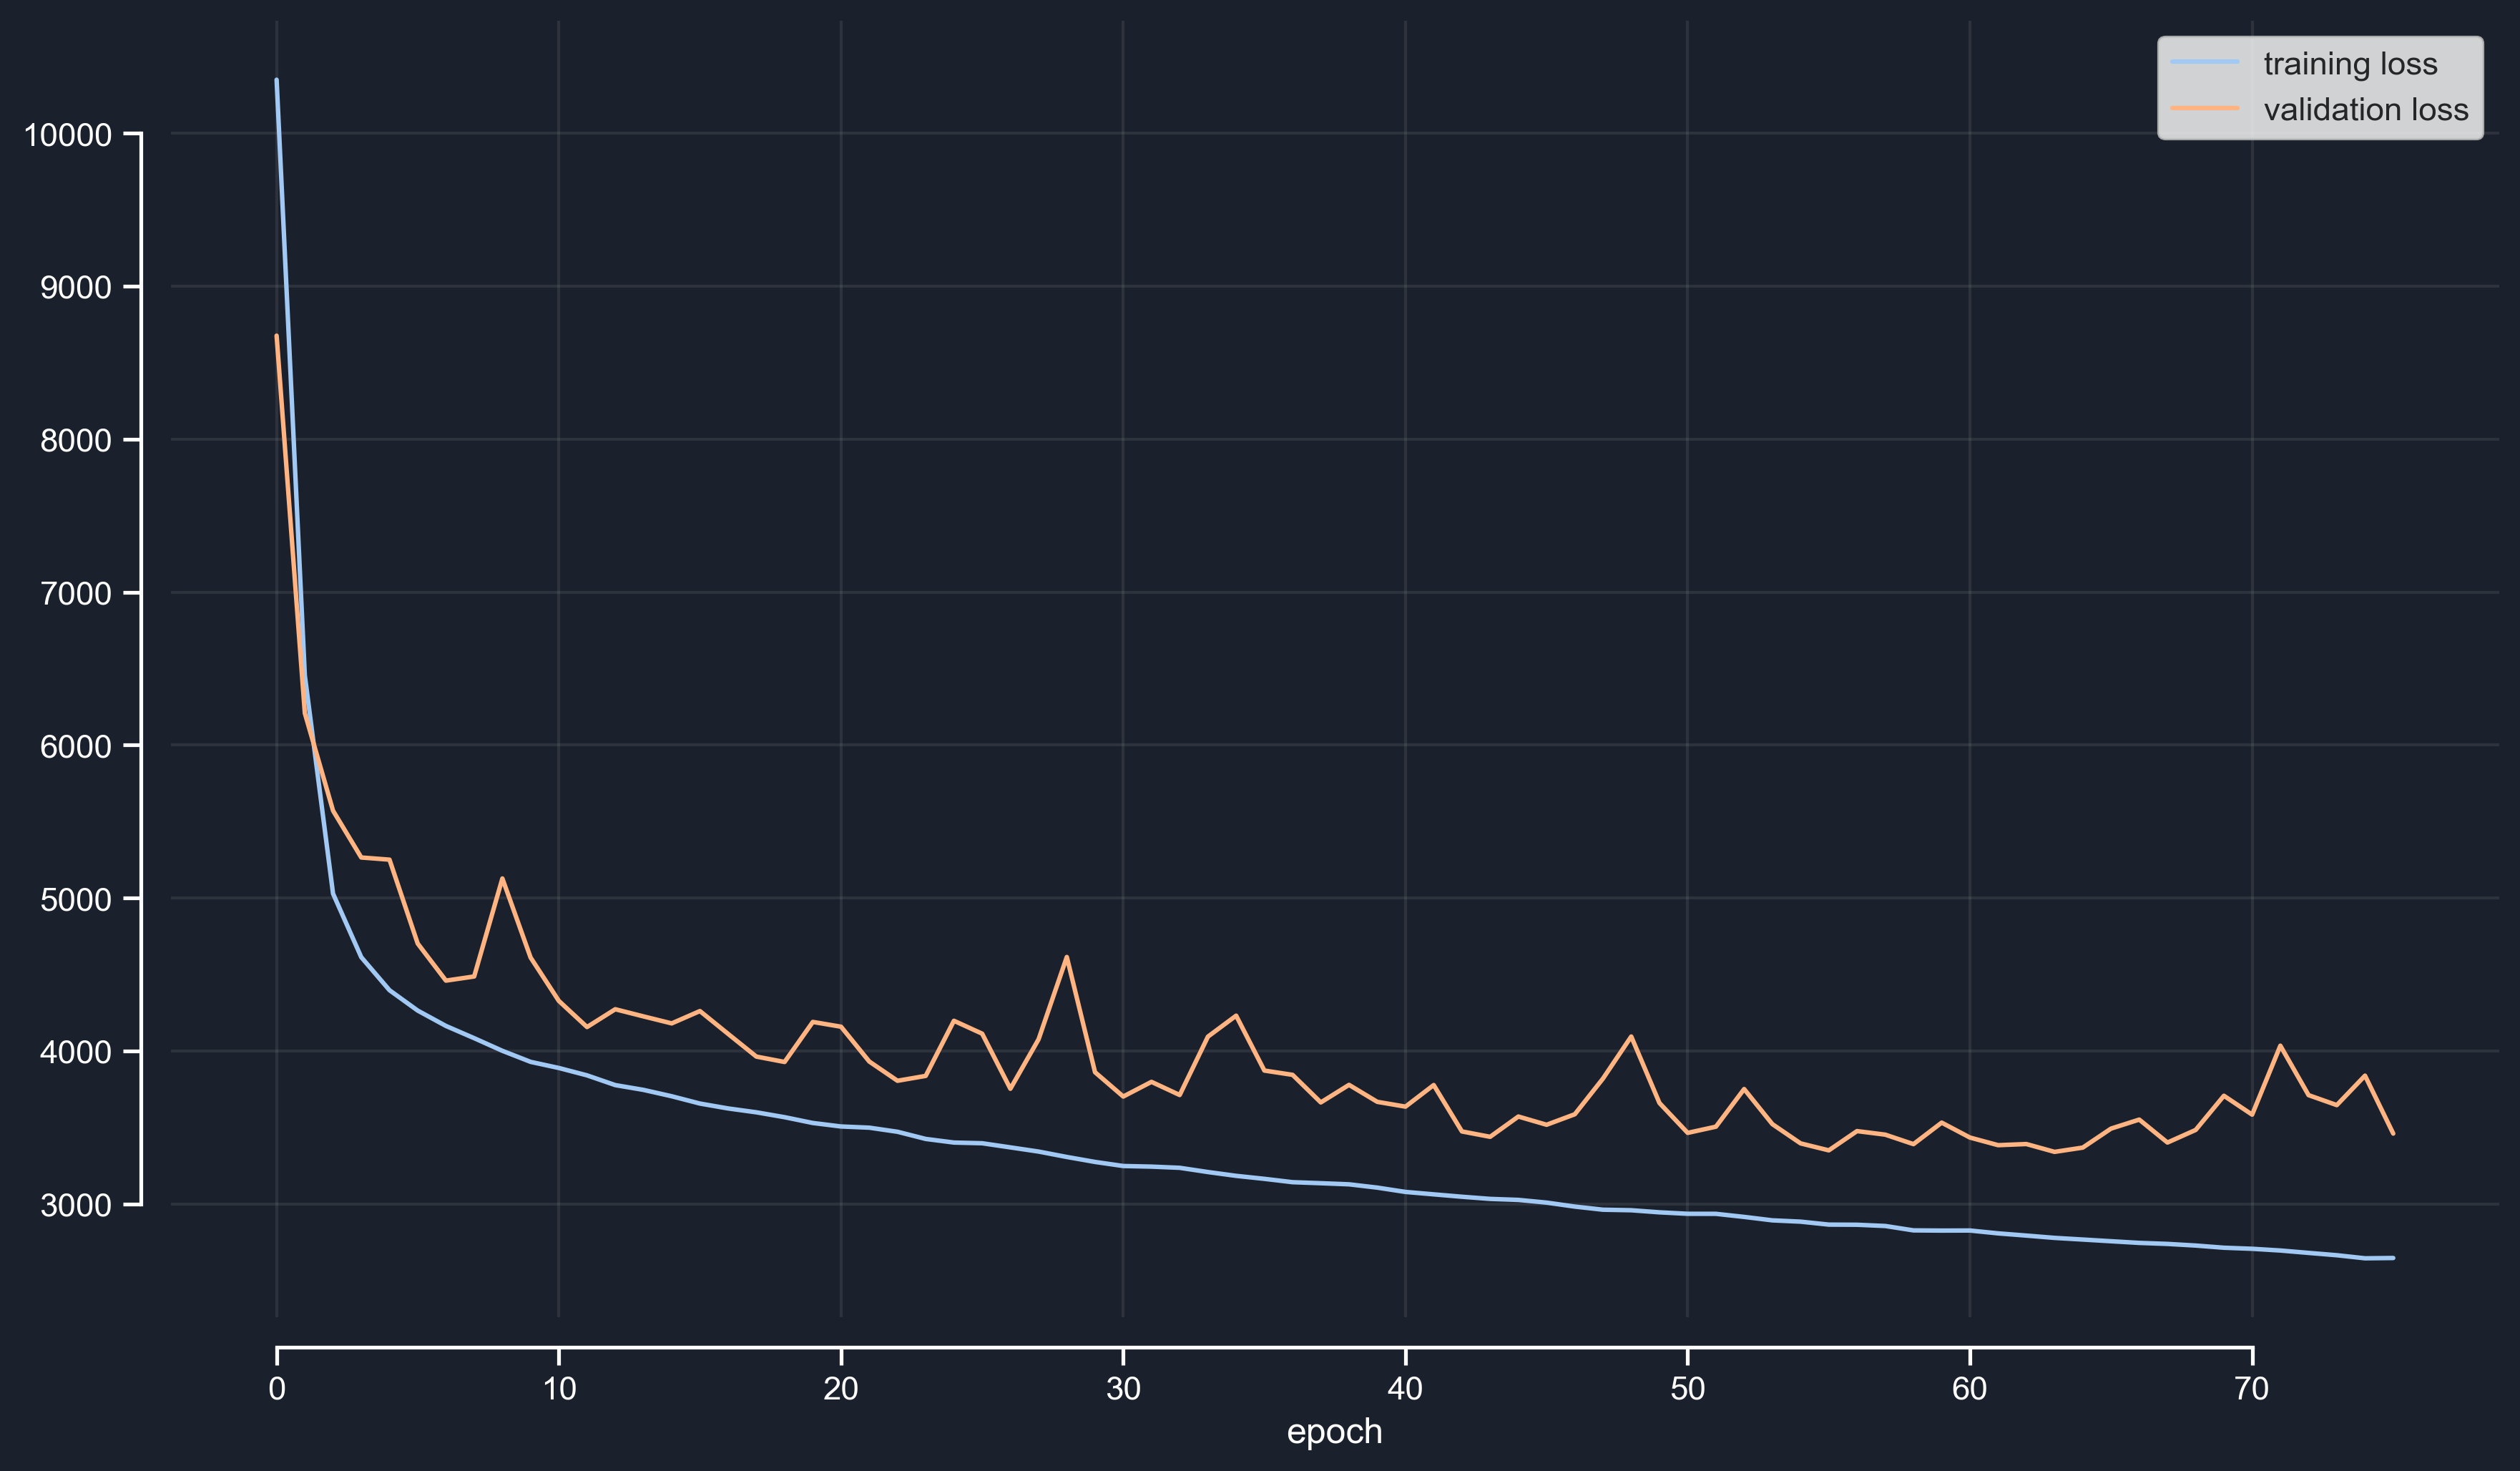

In [19]:
sns.set_theme(style="ticks", palette="pastel")
fig, ax = plt.subplots(figsize=(14, 8), dpi=300)

hist_df = pd.DataFrame(history.history)
sns.lineplot(x=hist_df.index, y=gaussian_filter1d(hist_df.loss, 0.6), ax=ax, label='training loss')
sns.lineplot(x=hist_df.index, y=gaussian_filter1d(hist_df.val_loss, 0.6), ax=ax, label='validation loss')
set_color(fig, ax)
sns.despine(offset=10, trim=True)
plt.xlabel('epoch')
plt.savefig('./nn_loss.png', dpi=300)
plt.show()

#### calculate r-squared

In [8]:
r2_score(y_test,model.predict(x=[cars_categorical_test[x] for x in cars_categorical_test.columns] + [cars_numerical_test]))


0.9505090002103066

#### calculate MAE

In [9]:
# print mean absolute error
print(mean_absolute_error(y_test, model.predict(x=[cars_categorical_test[x] for x in cars_categorical_test.columns] + [cars_numerical_test])))

2592.0127


#### calculate MSE

In [10]:
# print mean squared error
print(mean_squared_error(y_test, model.predict(x=[cars_categorical_test[x] for x in cars_categorical_test.columns] + [cars_numerical_test]))**0.5)

4922.022551756544


#### calculate MAPE

In [11]:
mean_absolute_percentage_error(y_test, model.predict(x=[cars_categorical_test[x] for x in cars_categorical_test.columns] + [cars_numerical_test]))

0.14315861

#### plot differences as a distplot

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


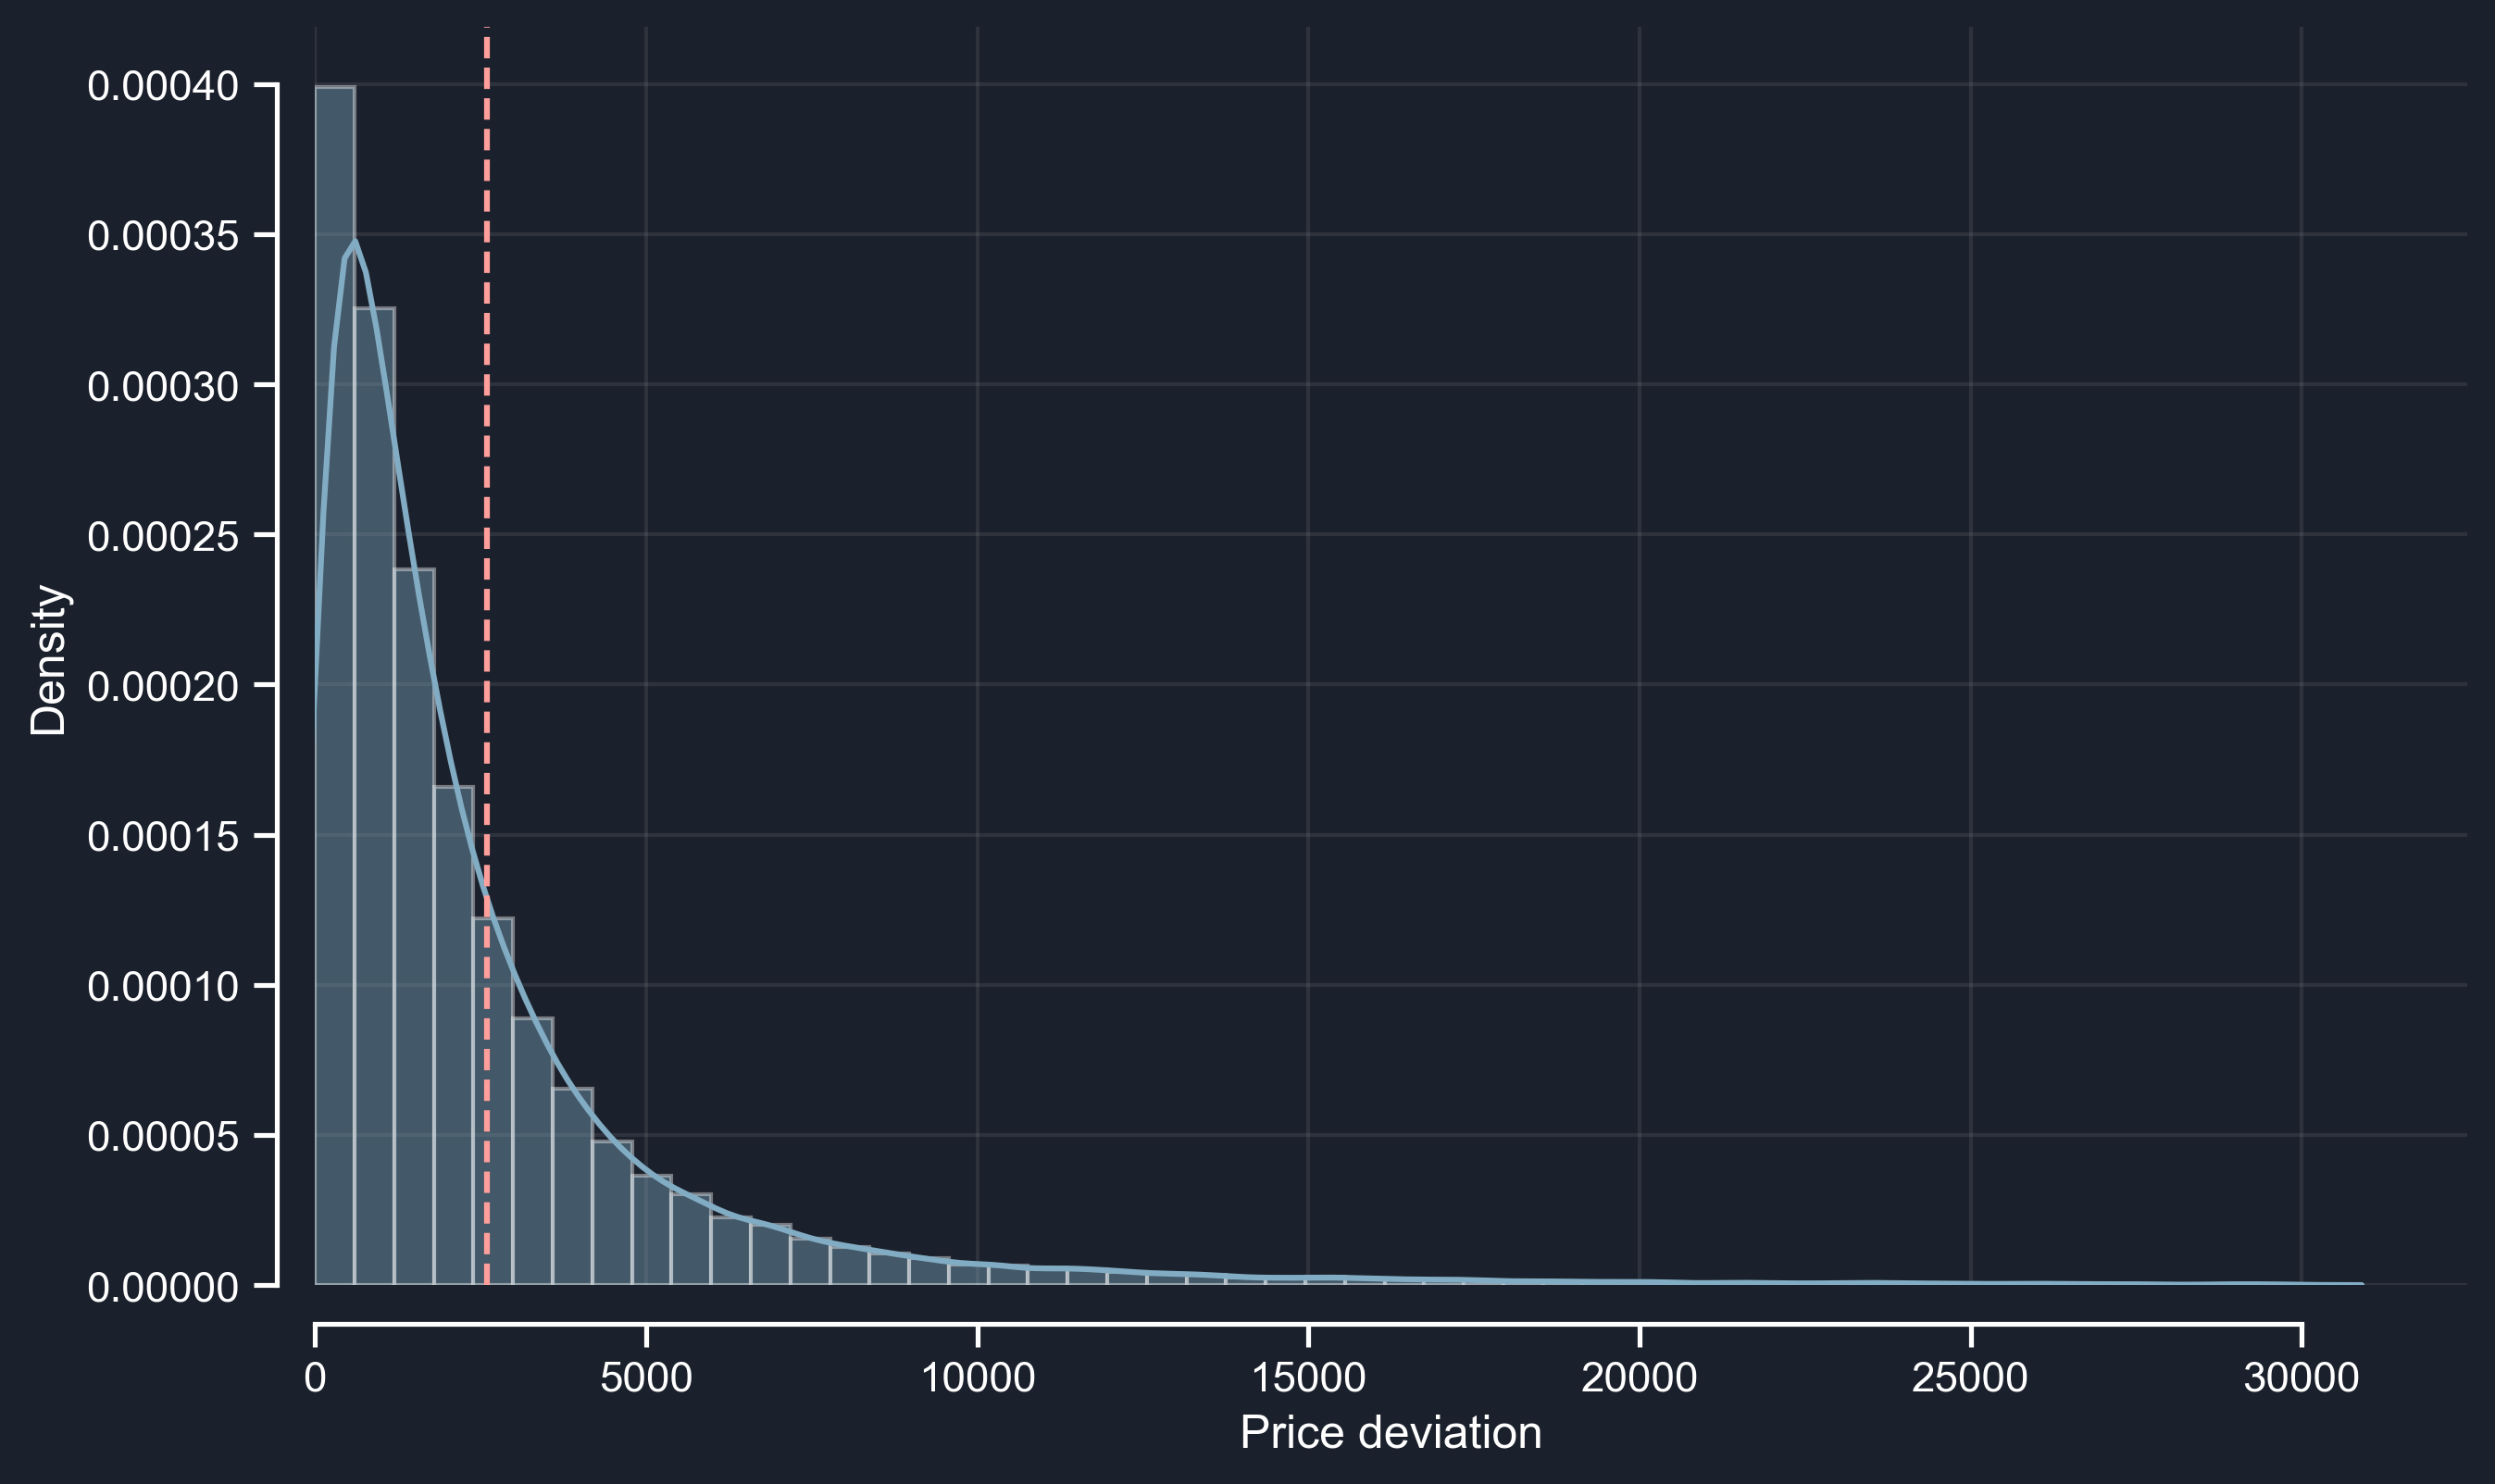

In [12]:
df = pd.DataFrame()


# add a column to y_test with the actual values
df['actual'] = y_test

# add a column to y_pred with the predicted value
df['predicted'] = model.predict(x=[cars_categorical_test[x] for x in cars_categorical_test.columns] + [cars_numerical_test])

df['diff'] = abs(df['actual'] - df['predicted'])

df2 = df[df["diff"] < 30000]

sns.set_theme(style="ticks", palette="pastel")
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
sns.distplot(df2["diff"], color="#81acc3", hist_kws=dict(alpha=0.4), fit_kws=dict(alpha=1), ax=ax)

plt.axvline(np.mean(df["diff"]), color='r', linestyle='--', label='Median')

sns.despine(offset=10, trim=True)
set_color(fig, ax)
plt.xlabel('Price deviation')
plt.xlim(0, None)
plt.savefig('./nn_error_dist.png', dpi=300)
plt.show()

#### save model

In [18]:
model.save('model.keras')